In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx
import importlib
import quasibi
from tqdm import tqdm
importlib.reload(quasibi);

In [3]:
# load the correlation matrices
pearson = quasibi.load_symmat("../output/pearson_correlation_matrix.npy")
rmd     = quasibi.load_symmat("../output/rmd_correlation_matrix.npy")
D       = quasibi.load_symmat("../output/distance.npy")

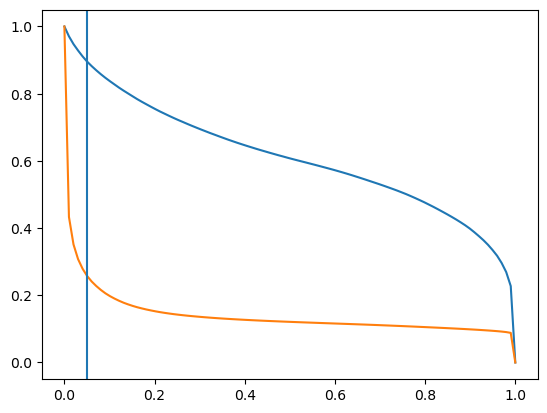

In [14]:
p = np.linspace(0, 1, 100)

plt.plot(p, np.quantile(pearson.flatten(), 1 - p)/np.max(pearson))
plt.plot(p, np.quantile(rmd.flatten(), 1 - p)/np.max(rmd))
plt.axvline(0.05)

In [7]:
ps = np.linspace(0, 0.1, 100)

H = np.zeros(100)

for i, p in enumerate(ps):
    pearson_threshold = np.abs(pearson) >= np.quantile(np.abs(pearson), 1 - p)
    rmd_threshold = np.abs(rmd) >= np.quantile(np.abs(rmd), 1 - p)
    
    H[i] = np.mean(pearson_threshold ^ rmd_threshold)

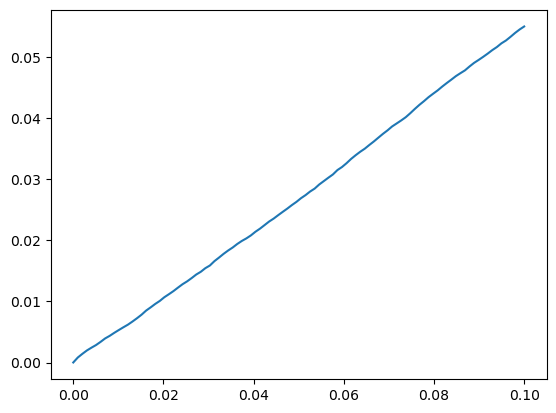

In [8]:
plt.plot(ps, H)